In [1]:
import math
import numpy
from gnuradio import gr, digital
from gnuradio import analog
from gnuradio import blocks
import sys
from ITpp import BCH_Encoder, BCH_Decoder


try:
    from scipy.special import comb
    from scipy.special import erfc
except ImportError:
    print "Error: could not import scipy (http://www.scipy.org/)"
    sys.exit(1)

try:
    import pylab
except ImportError:
    print "Error: could not import pylab (http://matplotlib.sourceforge.net/)"
    sys.exit(1)

# Best to choose powers of 10
#N_BITS = 1e7
N_BITS = 3e7
RAND_SEED = 42

In [2]:
def Q(x):
    return (0.5 * erfc(x/(numpy.sqrt(2))))

def Pb_BPSK(EbN0):
    return Q(numpy.sqrt(2*EbN0))

def Pb_DBPSK(EbN0):
    return 2 * Q(numpy.sqrt(2*EbN0)) - 2 * Q(numpy.sqrt(2*EbN0))**2

def from_dB(x):
    return math.pow(10, x/10)

def Pb_Hard_Codes(p, N, t):
    Sum = 0
    for m in range(t+1, N + 1):
        x = (m + t) * comb(N, m, exact = True, repetition = False) * p ** (m) * (1 - p) ** (N - m)
        Sum += x
    return Sum/N

def berawgn_BPSK(EbN0):
    """ Calculates theoretical bit error rate in AWGN (for BPSK and given Eb/N0) """
    return Pb_BPSK(from_dB(EbN0))

def berawgn_DBPSK(EbN0):
    """ Calculates theoretical bit error rate in AWGN (for DBPSK and given Eb/N0) """
    return Pb_DBPSK(from_dB(EbN0))


class BitErrors(gr.hier_block2):
    """ Two inputs: true and received bits. We compare them and
    add up the number of incorrect bits. Because integrate_ff()
    can only add up a certain number of values, the output is
    not a scalar, but a sequence of values, the sum of which is
    the BER. """
    def __init__(self, bits_per_byte):
        gr.hier_block2.__init__(self, "BitErrors",
                gr.io_signature(2, 2, gr.sizeof_char),
                gr.io_signature(1, 1, gr.sizeof_int))

        # Bit comparison
        comp = blocks.xor_bb()
        intdump_decim = 100000

	#print(bits_per_byte)

        if N_BITS < intdump_decim:
            intdump_decim = int(N_BITS)
        self.connect(self,
                     comp,
                     blocks.unpack_k_bits_bb(bits_per_byte),
                     blocks.uchar_to_float(),
                     blocks.integrate_ff(intdump_decim),
                     blocks.multiply_const_ff(1.0/N_BITS),
                     self)
        self.connect((self, 1), (comp, 1))

In [3]:
class BERAWGNSimu(gr.top_block):
    " This contains the simulation flow graph "
    def __init__(self, EbN0):
        gr.top_block.__init__(self)
        self.const = digital.bpsk_constellation()
        # Source is N_BITS bits, non-repeated

	#print("BITS PER SYMBOL: ", self.const.bits_per_symbol())
	#print("arity: ", self.const.arity())

        data = map(int, numpy.random.randint(0, self.const.arity(), int(N_BITS/self.const.bits_per_symbol())))
        src   = blocks.vector_source_b(data, False)
        mod   = digital.chunks_to_symbols_bc((self.const.points()), 1)
        add   = blocks.add_vcc()
	diff_enc = digital.diff_encoder_bb(2)
	diff_dec = digital.diff_decoder_bb(2)

	#print("Gaussian amplitude: ", self.EbN0_to_noise_voltage(EbN0))

        noise = analog.noise_source_c(analog.GR_GAUSSIAN,
                                      self.EbN0_to_noise_voltage(EbN0),
                                      RAND_SEED)
        demod = digital.constellation_decoder_cb(self.const.base())
        ber   = BitErrors(self.const.bits_per_symbol())
        self.sink  = blocks.vector_sink_f()
        self.connect(src, diff_enc, mod, add, demod, diff_dec, ber, self.sink)
        self.connect(noise, (add, 1))
        self.connect(src, (ber, 1))

    def EbN0_to_noise_voltage(self, EbN0):
        """ Converts Eb/N0 to a complex noise voltage (assuming unit symbol power) """
	#print("BITS PER SYMBOL: ", self.const.bits_per_symbol())
        return 1.0 / math.sqrt(self.const.bits_per_symbol() * 10**(float(EbN0)/10))

In [4]:
def simulate_ber(EbN0):
    """ All the work's done here: create flow graph, run, read out BER """
    print "Eb/N0 = {} dB".format(EbN0)
    fg = BERAWGNSimu(EbN0)
    fg.run()
    res = numpy.sum(fg.sink.data())
    print("BER: {}\n".format(res))
    return res

In [5]:
EbN0_min = 0
EbN0_max = 10
EbN0_range = range(EbN0_min, EbN0_max+1)
#EbN0_range = [0.5*x for x in range(EbN0_min*2, (EbN0_max+1)*2)]
ber_theory = [berawgn_DBPSK(float(x))      for x in EbN0_range]
ber_theory2 = [Pb_Hard_Codes(Pb_DBPSK(from_dB(float(x) - 10 * math.log10(float(15)/float(7)))), 15, 2)  for x in EbN0_range]

In [8]:
ber_simu = [simulate_ber(x) for x in EbN0_range]

Eb/N0 = 0 dB
BER: 0.144998596457

Eb/N0 = 1 dB
BER: 0.106298330706

Eb/N0 = 2 dB
BER: 0.072280198583

Eb/N0 = 3 dB
BER: 0.0447519322915

Eb/N0 = 4 dB
BER: 0.0247475993747

Eb/N0 = 5 dB
BER: 0.0118202663762

Eb/N0 = 6 dB
BER: 0.0047895998905

Eb/N0 = 7 dB
BER: 0.0015454666252

Eb/N0 = 8 dB
BER: 0.000381599990192

Eb/N0 = 9 dB
BER: 7.00666642999e-05

Eb/N0 = 10 dB
BER: 8.86666643396e-06



In [11]:
class BERAWGNSimu2(gr.top_block):
    " This contains the simulation flow graph "
    def __init__(self, EbN0):
        gr.top_block.__init__(self)
        self.const = digital.bpsk_constellation()
        # Source is N_BITS bits, non-repeated

        #print("BITS PER SYMBOL: ", self.const.bits_per_symbol())
        #print("arity: ", self.const.arity())

        data = map(int, numpy.random.randint(0, self.const.arity(), int(N_BITS/self.const.bits_per_symbol())))
        src   = blocks.vector_source_b(data, False)
        enc   = BCH_Encoder(15, 2)
        mod   = digital.chunks_to_symbols_bc((self.const.points()), 1)
        add   = blocks.add_vcc()
        diff_enc = digital.diff_encoder_bb(2)
        diff_dec = digital.diff_decoder_bb(2)

        #print("Gaussian amplitude: ", self.EbN0_to_noise_voltage(EbN0))

        noise = analog.noise_source_c(analog.GR_GAUSSIAN,
                                      self.EbN0_to_noise_voltage(EbN0),
                                      RAND_SEED)
        demod = digital.constellation_decoder_cb(self.const.base())
        dec   = BCH_Decoder(15, 2)
        ber   = BitErrors(self.const.bits_per_symbol())
        self.sink  = blocks.vector_sink_f()
        self.connect(src, diff_enc, enc, mod, add, demod, dec, diff_dec, ber, self.sink)
        self.connect(noise, (add, 1))
        self.connect(src, (ber, 1))

    def EbN0_to_noise_voltage(self, EbN0):
        """ Converts Eb/N0 to a complex noise voltage (assuming unit symbol power) """
        #print("BITS PER SYMBOL: ", self.const.bits_per_symbol())
        return 1.0 / math.sqrt(self.const.bits_per_symbol() * 10**(float(EbN0-10*math.log10(15.0/7.0))/10))

In [12]:
def simulate_ber2(EbN0):
    """ All the work's done here: create flow graph, run, read out BER """
    print "Eb/N0 = {} dB".format(EbN0)
    fg = BERAWGNSimu2(EbN0)
    fg.run()
    res = numpy.sum(fg.sink.data())
    print("BER: {}\n".format(res))
    return res

In [15]:
class BERAWGNSimu3(gr.top_block):
    " This contains the simulation flow graph "
    def __init__(self, EbN0):
        gr.top_block.__init__(self)
        self.const = digital.bpsk_constellation()
        # Source is N_BITS bits, non-repeated

        #print("BITS PER SYMBOL: ", self.const.bits_per_symbol())
        #print("arity: ", self.const.arity())

        data = map(int, numpy.random.randint(0, self.const.arity(), int(N_BITS/self.const.bits_per_symbol())))
        src   = blocks.vector_source_b(data, False)
        enc   = BCH_Encoder(15, 2)
        mod   = digital.chunks_to_symbols_bc((self.const.points()), 1)
        add   = blocks.add_vcc()
        diff_enc = digital.diff_encoder_bb(2)
        diff_enc2 = digital.diff_encoder_bb(2)
        diff_dec = digital.diff_decoder_bb(2)
        diff_dec2 = digital.diff_decoder_bb(2)

        #print("Gaussian amplitude: ", self.EbN0_to_noise_voltage(EbN0))

        noise = analog.noise_source_c(analog.GR_GAUSSIAN,
                                      self.EbN0_to_noise_voltage(EbN0),
                                      RAND_SEED)
        demod = digital.constellation_decoder_cb(self.const.base())
        dec   = BCH_Decoder(15, 2)
        ber   = BitErrors(self.const.bits_per_symbol())
        self.sink  = blocks.vector_sink_f()
        self.connect(src, diff_enc, diff_enc2, enc, mod, add, demod, dec, diff_dec, diff_dec2, ber, self.sink)
        self.connect(noise, (add, 1))
        self.connect(src, (ber, 1))

    def EbN0_to_noise_voltage(self, EbN0):
        """ Converts Eb/N0 to a complex noise voltage (assuming unit symbol power) """
        #print("BITS PER SYMBOL: ", self.const.bits_per_symbol())
        return 1.0 / math.sqrt(self.const.bits_per_symbol() * 10**(float(EbN0-10*math.log10(15.0/7.0))/10))

In [16]:
def simulate_ber3(EbN0):
    """ All the work's done here: create flow graph, run, read out BER """
    print "Eb/N0 = {} dB".format(EbN0)
    fg = BERAWGNSimu3(EbN0)
    fg.run()
    res = numpy.sum(fg.sink.data())
    print("BER: {}\n".format(res))
    return res

In [21]:
class BERAWGNSimu4(gr.top_block):
    " This contains the simulation flow graph "
    def __init__(self, EbN0):
        gr.top_block.__init__(self)
        self.const = digital.bpsk_constellation()
        # Source is N_BITS bits, non-repeated

        #print("BITS PER SYMBOL: ", self.const.bits_per_symbol())
        #print("arity: ", self.const.arity())

        data = map(int, numpy.random.randint(0, self.const.arity(), int(N_BITS/self.const.bits_per_symbol())))
        src   = blocks.vector_source_b(data, False)
        enc   = BCH_Encoder(15, 2)
        mod   = digital.chunks_to_symbols_bc((self.const.points()), 1)
        add   = blocks.add_vcc()
        diff_enc = digital.diff_encoder_bb(2)
        diff_enc2 = digital.diff_encoder_bb(2)
        diff_enc3 = digital.diff_encoder_bb(2)
        diff_dec = digital.diff_decoder_bb(2)
        diff_dec2 = digital.diff_decoder_bb(2)
        diff_dec3 = digital.diff_decoder_bb(2)

        #print("Gaussian amplitude: ", self.EbN0_to_noise_voltage(EbN0))

        noise = analog.noise_source_c(analog.GR_GAUSSIAN,
                                      self.EbN0_to_noise_voltage(EbN0),
                                      RAND_SEED)
        demod = digital.constellation_decoder_cb(self.const.base())
        dec   = BCH_Decoder(15, 2)
        ber   = BitErrors(self.const.bits_per_symbol())
        self.sink  = blocks.vector_sink_f()
        self.connect(src, diff_enc, diff_enc2, diff_enc3, enc, mod, add, demod, dec, diff_dec, diff_dec2, diff_dec3, ber, self.sink)
        self.connect(noise, (add, 1))
        self.connect(src, (ber, 1))

    def EbN0_to_noise_voltage(self, EbN0):
        """ Converts Eb/N0 to a complex noise voltage (assuming unit symbol power) """
        #print("BITS PER SYMBOL: ", self.const.bits_per_symbol())
        return 1.0 / math.sqrt(self.const.bits_per_symbol() * 10**(float(EbN0-10*math.log10(15.0/7.0))/10))

In [22]:
def simulate_ber4(EbN0):
    """ All the work's done here: create flow graph, run, read out BER """
    print "Eb/N0 = {} dB".format(EbN0)
    fg = BERAWGNSimu4(EbN0)
    fg.run()
    res = numpy.sum(fg.sink.data())
    print("BER: {}\n".format(res))
    return res

In [13]:
ber_simu2  = [simulate_ber2(x) for x in EbN0_range]

Eb/N0 = 0 dB
BER: 0.240687328158

Eb/N0 = 1 dB
BER: 0.180432395835

Eb/N0 = 2 dB
BER: 0.120906530297

Eb/N0 = 3 dB
BER: 0.0702411982202

Eb/N0 = 4 dB
BER: 0.0337967992018

Eb/N0 = 5 dB
BER: 0.0128949330283

Eb/N0 = 6 dB
BER: 0.00368499990873

Eb/N0 = 7 dB
BER: 0.000738466647022

Eb/N0 = 8 dB
BER: 9.43999968754e-05

Eb/N0 = 9 dB
BER: 7.13333314195e-06

Eb/N0 = 10 dB
BER: 6.66666643667e-07



In [17]:
ber_simu3  = [simulate_ber3(x) for x in EbN0_range]

Eb/N0 = 0 dB
BER: 0.26385809388

Eb/N0 = 1 dB
BER: 0.200091794773

Eb/N0 = 2 dB
BER: 0.135840197006

Eb/N0 = 3 dB
BER: 0.0795364647056

Eb/N0 = 4 dB
BER: 0.0386475990599

Eb/N0 = 5 dB
BER: 0.0148534662912

Eb/N0 = 6 dB
BER: 0.00424393323192

Eb/N0 = 7 dB
BER: 0.000842666644644

Eb/N0 = 8 dB
BER: 0.000116999996159

Eb/N0 = 9 dB
BER: 7.93333303761e-06

Eb/N0 = 10 dB
BER: 7.33333308744e-07



In [23]:
ber_simu4  = [simulate_ber4(x) for x in EbN0_range]

Eb/N0 = 0 dB
BER: 0.279784126324

Eb/N0 = 1 dB
BER: 0.21505266137

Eb/N0 = 2 dB
BER: 0.147639929841

Eb/N0 = 3 dB
BER: 0.0872941314592

Eb/N0 = 4 dB
BER: 0.042621599132

Eb/N0 = 5 dB
BER: 0.0163214662425

Eb/N0 = 6 dB
BER: 0.00474673321969

Eb/N0 = 7 dB
BER: 0.000924666642391

Eb/N0 = 8 dB
BER: 0.000130666662443

Eb/N0 = 9 dB
BER: 7.93333307314e-06

Eb/N0 = 10 dB
BER: 0.0



In [26]:
class BERAWGNSimu2A(gr.top_block):
    " This contains the simulation flow graph "
    def __init__(self, EbN0):
        gr.top_block.__init__(self)
        self.const = digital.bpsk_constellation()
        # Source is N_BITS bits, non-repeated

        #print("BITS PER SYMBOL: ", self.const.bits_per_symbol())
        #print("arity: ", self.const.arity())

        data = map(int, numpy.random.randint(0, self.const.arity(), int(N_BITS/self.const.bits_per_symbol())))
        src   = blocks.vector_source_b(data, False)
        enc   = BCH_Encoder(15, 2)
        mod   = digital.chunks_to_symbols_bc((self.const.points()), 1)
        add   = blocks.add_vcc()
        diff_enc = digital.diff_encoder_bb(2)
        diff_dec = digital.diff_decoder_bb(2)

        #print("Gaussian amplitude: ", self.EbN0_to_noise_voltage(EbN0))

        noise = analog.noise_source_c(analog.GR_GAUSSIAN,
                                      self.EbN0_to_noise_voltage(EbN0),
                                      RAND_SEED)
        demod = digital.constellation_decoder_cb(self.const.base())
        dec   = BCH_Decoder(15, 2)
        ber   = BitErrors(self.const.bits_per_symbol())
        self.sink  = blocks.vector_sink_f()
        self.connect(src, enc, diff_enc, mod, add, demod, diff_dec, dec, ber, self.sink)
        self.connect(noise, (add, 1))
        self.connect(src, (ber, 1))

    def EbN0_to_noise_voltage(self, EbN0):
        """ Converts Eb/N0 to a complex noise voltage (assuming unit symbol power) """
        #print("BITS PER SYMBOL: ", self.const.bits_per_symbol())
        return 1.0 / math.sqrt(self.const.bits_per_symbol() * 10**(float(EbN0-10*math.log10(15.0/7.0))/10))

In [27]:
def simulate_ber2A(EbN0):
    """ All the work's done here: create flow graph, run, read out BER """
    print "Eb/N0 = {} dB".format(EbN0)
    fg = BERAWGNSimu2A(EbN0)
    fg.run()
    res = numpy.sum(fg.sink.data())
    print("BER: {}\n".format(res))
    return res

In [34]:
class BERAWGNSimu3A(gr.top_block):
    " This contains the simulation flow graph "
    def __init__(self, EbN0):
        gr.top_block.__init__(self)
        self.const = digital.bpsk_constellation()
        # Source is N_BITS bits, non-repeated

        #print("BITS PER SYMBOL: ", self.const.bits_per_symbol())
        #print("arity: ", self.const.arity())

        data = map(int, numpy.random.randint(0, self.const.arity(), int(N_BITS/self.const.bits_per_symbol())))
        src   = blocks.vector_source_b(data, False)
        enc   = BCH_Encoder(15, 2)
        mod   = digital.chunks_to_symbols_bc((self.const.points()), 1)
        add   = blocks.add_vcc()
        diff_enc = digital.diff_encoder_bb(2)
        diff_enc2 = digital.diff_encoder_bb(2)
        diff_dec = digital.diff_decoder_bb(2)
        diff_dec2 = digital.diff_decoder_bb(2)

        #print("Gaussian amplitude: ", self.EbN0_to_noise_voltage(EbN0))

        noise = analog.noise_source_c(analog.GR_GAUSSIAN,
                                      self.EbN0_to_noise_voltage(EbN0),
                                      RAND_SEED)
        demod = digital.constellation_decoder_cb(self.const.base())
        dec   = BCH_Decoder(15, 2)
        ber   = BitErrors(self.const.bits_per_symbol())
        self.sink  = blocks.vector_sink_f()
        self.connect(src, enc, diff_enc, diff_enc2, mod, add, demod, diff_dec2, diff_dec, dec, ber, self.sink)
        self.connect(noise, (add, 1))
        self.connect(src, (ber, 1))

    def EbN0_to_noise_voltage(self, EbN0):
        """ Converts Eb/N0 to a complex noise voltage (assuming unit symbol power) """
        #print("BITS PER SYMBOL: ", self.const.bits_per_symbol())
        return 1.0 / math.sqrt(self.const.bits_per_symbol() * 10**(float(EbN0-10*math.log10(15.0/7.0))/10))

In [35]:
def simulate_ber3A(EbN0):
    """ All the work's done here: create flow graph, run, read out BER """
    print "Eb/N0 = {} dB".format(EbN0)
    fg = BERAWGNSimu3A(EbN0)
    fg.run()
    res = numpy.sum(fg.sink.data())
    print("BER: {}\n".format(res))
    return res

In [36]:
ber_simu3A  = [simulate_ber3A(x) for x in EbN0_range]

Eb/N0 = 0 dB
BER: 0.356604723609

Eb/N0 = 1 dB
BER: 0.307794992463

Eb/N0 = 2 dB
BER: 0.248849661148

Eb/N0 = 3 dB
BER: 0.183650062478

Eb/N0 = 4 dB
BER: 0.119740063703

Eb/N0 = 5 dB
BER: 0.0667394651682

Eb/N0 = 6 dB
BER: 0.0304286659011

Eb/N0 = 7 dB
BER: 0.0108886663875

Eb/N0 = 8 dB
BER: 0.00290609993408

Eb/N0 = 9 dB
BER: 0.000546099984092

Eb/N0 = 10 dB
BER: 6.8166664505e-05



In [41]:
class BERAWGNSimu2C(gr.top_block):
    " This contains the simulation flow graph "
    def __init__(self, EbN0):
        gr.top_block.__init__(self)
        self.const = digital.bpsk_constellation()
        # Source is N_BITS bits, non-repeated

        #print("BITS PER SYMBOL: ", self.const.bits_per_symbol())
        #print("arity: ", self.const.arity())

        data = map(int, numpy.random.randint(0, self.const.arity(), int(N_BITS/self.const.bits_per_symbol())))
        src   = blocks.vector_source_b(data, False)
        enc   = BCH_Encoder(15, 2)
        mod   = digital.chunks_to_symbols_bc((self.const.points()), 1)
        add   = blocks.add_vcc()
        diff_enc = digital.diff_encoder_bb(2)
        diff_enc2 = digital.diff_encoder_bb(2)
        diff_dec = digital.diff_decoder_bb(2)
        diff_dec2 = digital.diff_decoder_bb(2)

        #print("Gaussian amplitude: ", self.EbN0_to_noise_voltage(EbN0))

        noise = analog.noise_source_c(analog.GR_GAUSSIAN,
                                      self.EbN0_to_noise_voltage(EbN0),
                                      RAND_SEED)
        demod = digital.constellation_decoder_cb(self.const.base())
        dec   = BCH_Decoder(15, 2)
        ber   = BitErrors(self.const.bits_per_symbol())
        self.sink  = blocks.vector_sink_f()
        self.connect(src, diff_enc, enc, diff_enc2, mod, add, demod, diff_dec2, dec, diff_dec, ber, self.sink)
        self.connect(noise, (add, 1))
        self.connect(src, (ber, 1))

    def EbN0_to_noise_voltage(self, EbN0):
        """ Converts Eb/N0 to a complex noise voltage (assuming unit symbol power) """
        #print("BITS PER SYMBOL: ", self.const.bits_per_symbol())
        return 1.0 / math.sqrt(self.const.bits_per_symbol() * 10**(float(EbN0-10*math.log10(15.0/7.0))/10))

In [43]:
def simulate_ber2C(EbN0):
    """ All the work's done here: create flow graph, run, read out BER """
    print "Eb/N0 = {} dB".format(EbN0)
    fg = BERAWGNSimu2C(EbN0)
    fg.run()
    res = numpy.sum(fg.sink.data())
    print("BER: {}\n".format(res))
    return res

In [45]:
ber_simu2C  = [simulate_ber2C(x) for x in EbN0_range]

Eb/N0 = 0 dB
BER: 0.363246558001

Eb/N0 = 1 dB
BER: 0.314498059452

Eb/N0 = 2 dB
BER: 0.254846994125

Eb/N0 = 3 dB
BER: 0.188536329253

Eb/N0 = 4 dB
BER: 0.123387330503

Eb/N0 = 5 dB
BER: 0.0689361982368

Eb/N0 = 6 dB
BER: 0.0314993992724

Eb/N0 = 7 dB
BER: 0.0112773997353

Eb/N0 = 8 dB
BER: 0.00300306659346

Eb/N0 = 9 dB
BER: 0.000566599986598

Eb/N0 = 10 dB
BER: 6.33999978206e-05



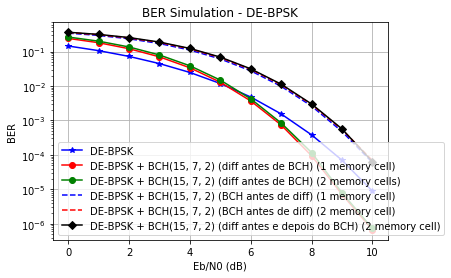

In [54]:
f = pylab.figure()
s = f.add_subplot(1,1,1)
# s.semilogy(EbN0_range, ber_theory, 'g-.', label="Theoretical DE-BPSK")
#s.semilogy(EbN0_range, ber_theory2, 'y-.', label="Theoretical DE-BPSK + BCH(15, 7, 2)")
s.semilogy(EbN0_range, ber_simu, 'b-*', label="DE-BPSK")
s.semilogy(EbN0_range, ber_simu2, 'r-o', label="DE-BPSK + BCH(15, 7, 2) (diff antes de BCH) (1 memory cell)")
s.semilogy(EbN0_range, ber_simu3, 'g-o', label="DE-BPSK + BCH(15, 7, 2) (diff antes de BCH) (2 memory cells)")
# s.semilogy(EbN0_range, ber_simu4, 'y-o', label="DE-BPSK + BCH(15, 7, 2) (diff antes de BCH) (3 memory cells)")
s.semilogy(EbN0_range, ber_simu2A, 'b--', label="DE-BPSK + BCH(15, 7, 2) (BCH antes de diff) (1 memory cell)")
s.semilogy(EbN0_range, ber_simu3A, 'r--', label="DE-BPSK + BCH(15, 7, 2) (BCH antes de diff) (2 memory cell)")
s.semilogy(EbN0_range, ber_simu2C, 'k-D', label="DE-BPSK + BCH(15, 7, 2) (diff antes e depois do BCH) (2 memory cell)")


s.set_title('BER Simulation - DE-BPSK')
s.set_xlabel('Eb/N0 (dB)')
s.set_ylabel('BER')
s.legend()
s.grid()
# pylab.savefig("plot-no-legend.pdf", dpi = 300)
pylab.show()

In [47]:
numpy.save("simu_de-bpsk-no-code", ber_simu)
numpy.save("simu_de-bpsk-bch-15-7-2-1cell-before-coding", ber_simu2)
numpy.save("simu_de-bpsk-bch-15-7-2-2cell-before-coding", ber_simu3)
numpy.save("simu_de-bpsk-bch-15-7-2-3cell-before-coding", ber_simu4)
numpy.save("simu_de-bpsk-bch-15-7-2-1cell-after-coding", ber_simu2A)
numpy.save("simu_de-bpsk-bch-15-7-2-2cell-after-coding", ber_simu3A)
numpy.save("simu_de-bpsk-bch-15-7-2-2cell-before-and-after-coding", ber_simu2C)